# Evaluate submissions

## Loading submission and reference directories

In [1]:
import os

In [2]:
datapath_submission = "path/to/housediffusion-mrr-wca"
datapath_reference = "/path/to/modified-swiss-dwellings-v2/test/"


In [3]:
model = 'housediffusion'
struct_post_processing = False
mrr = True
wca = False

assert struct_post_processing == False

sub_name = f'{model}-{"mrr" if mrr else "full"}' \
           f'{"-wca" if wca else ""}'
        #    f'{"-with-structure" if struct else ""}'

sub_name = "submission"

# Define reference and submission roots
ref_root = os.path.join(datapath_reference, 'full_out')
sub_root = os.path.join(datapath_submission, sub_name)

# Get identity sets for reference and submission
ids_ref = set([int(f[:-4]) for f in os.listdir(ref_root)])
# ids_sub = set([int(f[:-4]) for f in os.listdir(sub_root)])
ids_sub = set([int(f[:-4]) for f in os.listdir(sub_root)])

overlap = ids_ref.intersection(ids_sub)

# Print reference and submission identity properties
# Overlap should be the full set (!)
print(f'Length dataset REF:\t{len(ids_ref)}')
print(f'Length dataset SUB:\t{len(ids_sub)}')
print(f'Length of overlap:\t{len(overlap)}')

# print(f"{sub_root=}")

Length dataset REF:	800
Length dataset SUB:	791
Length of overlap:	791


## Add image folder (to scroll through)

Create new folder

In [4]:
image_path = sub_root + '-images'
os.makedirs(image_path, exist_ok=True)

## Plotting examples

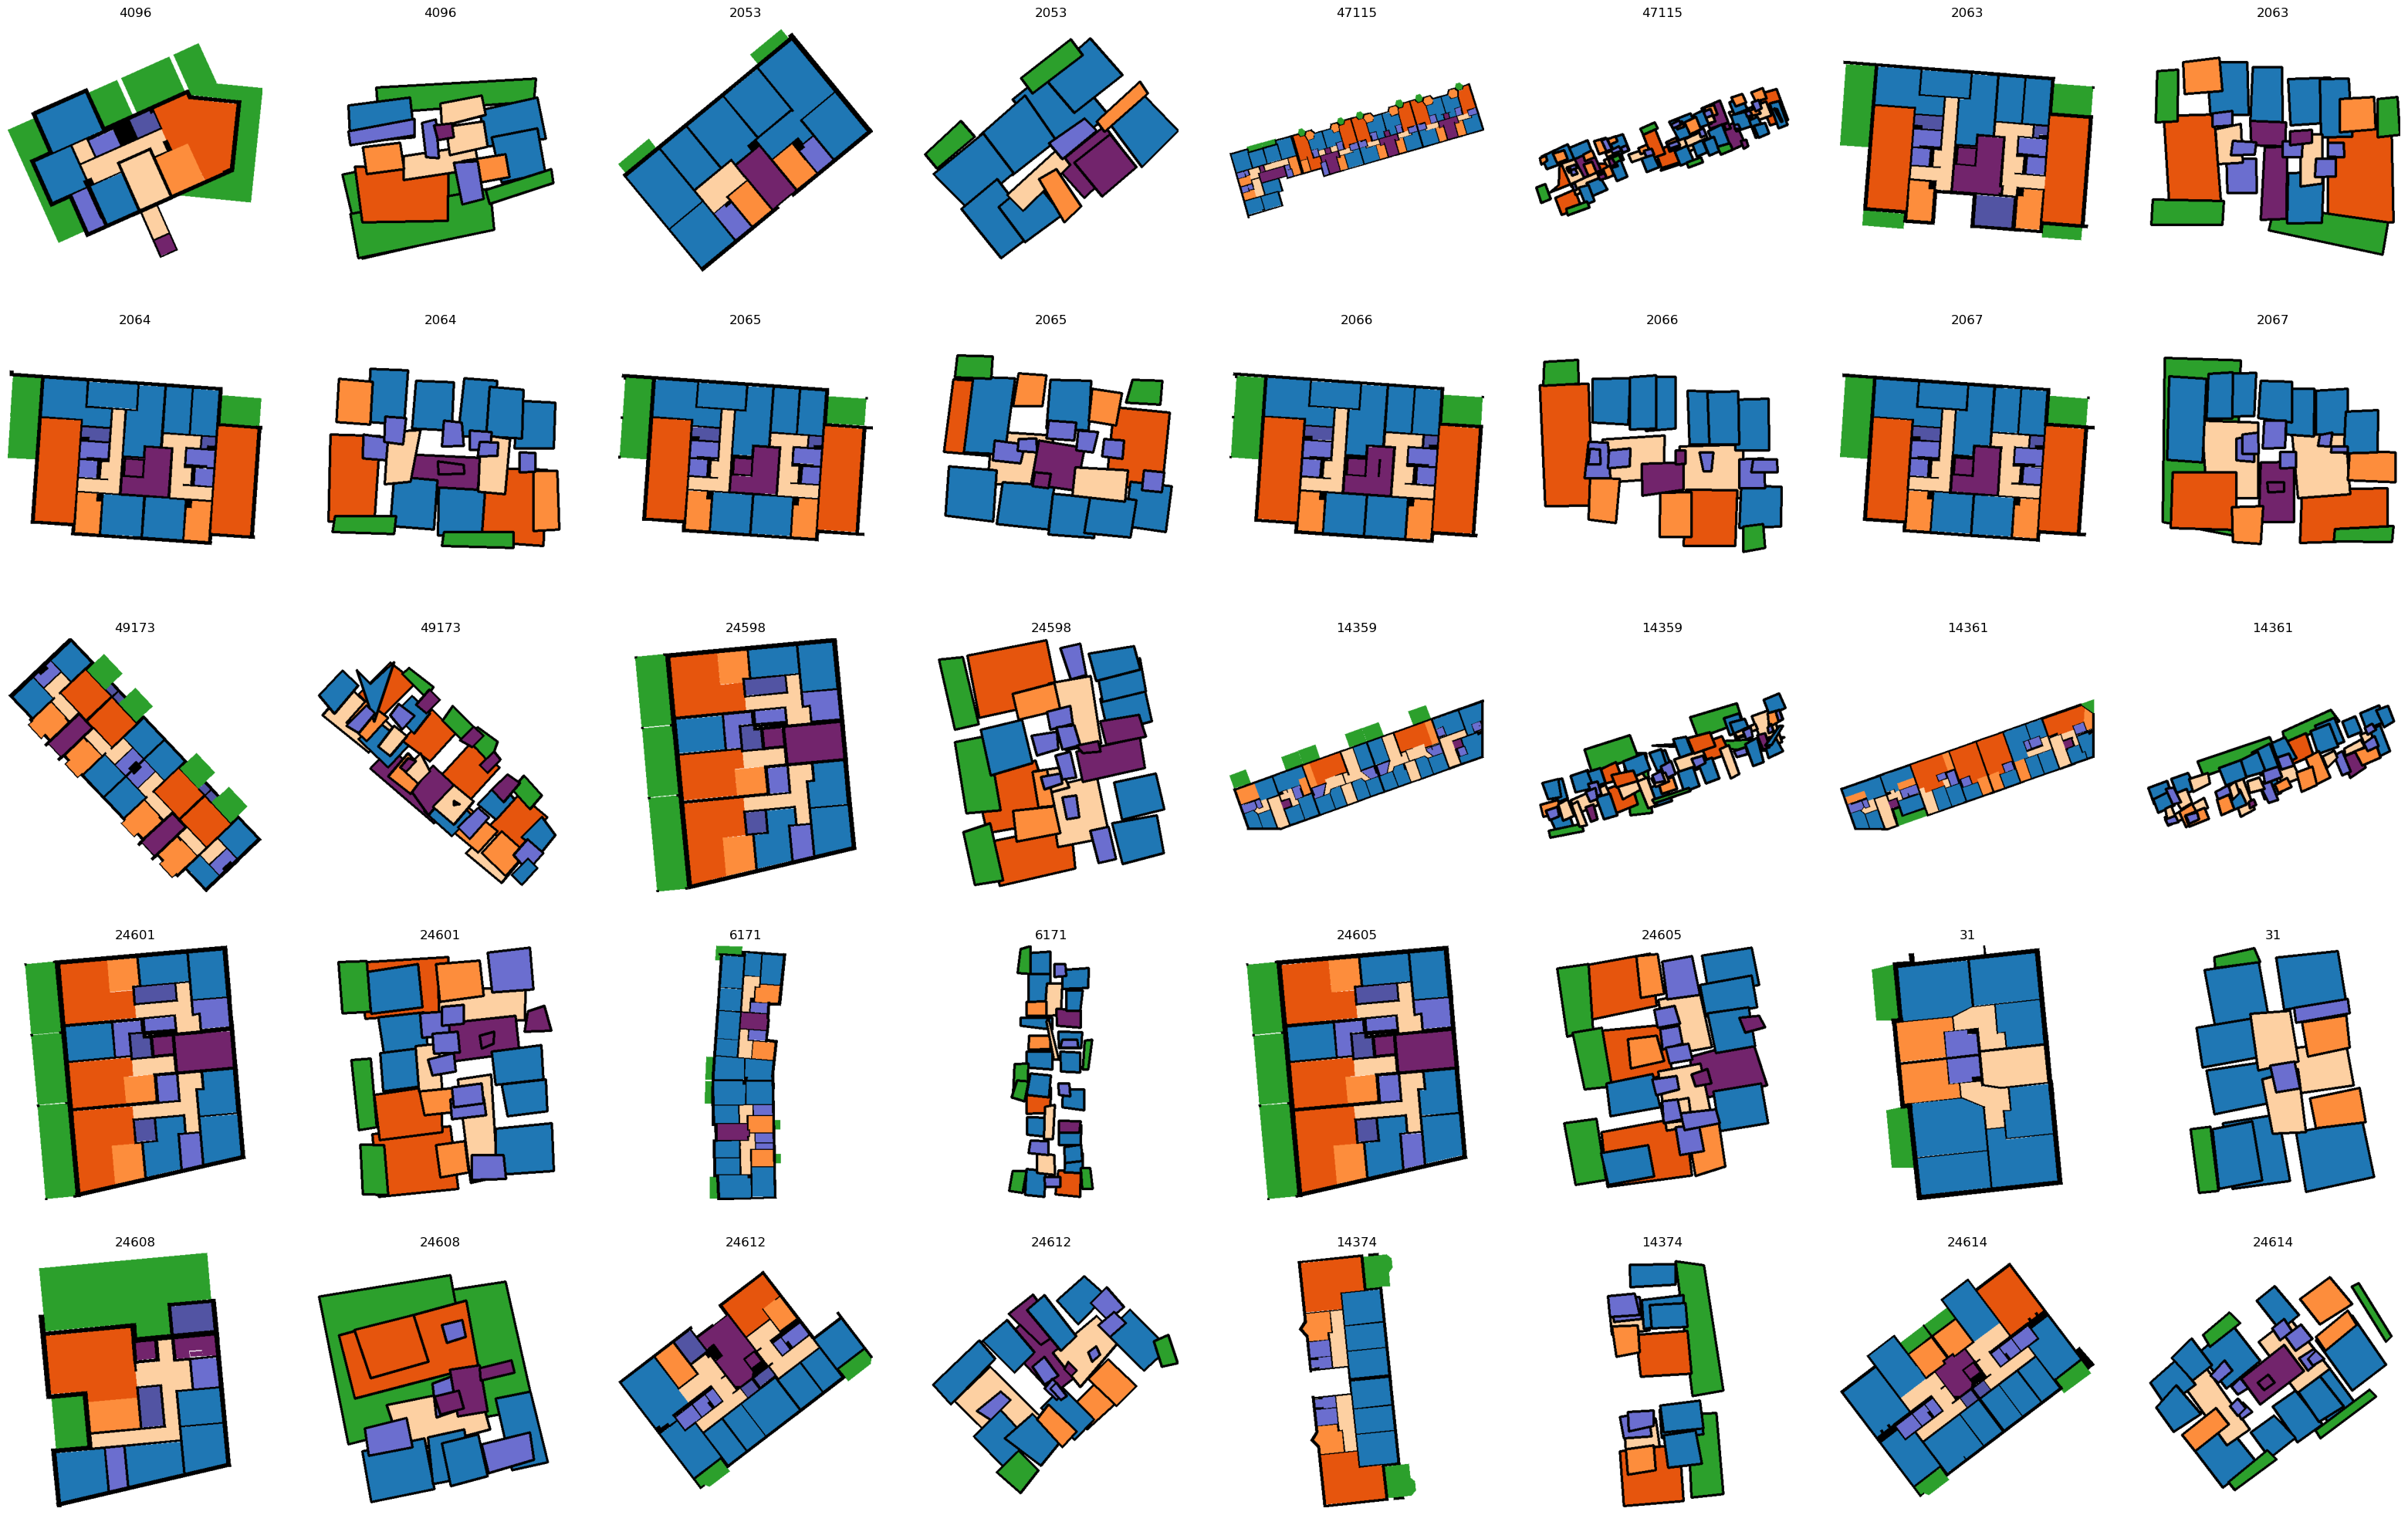

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# from plot import set_figure
from constants import CMAP_ROOMTYPE
from utils import colorize_floorplan

CLASSES = np.arange(0, 10)

def load_image(path, kind='sub'):

    # submissions are saved as .png
    if kind == 'sub':
        img = (plt.imread(path)*255).astype(np.uint8)

    # references are saved as .npy
    elif kind == 'ref':
        img = np.load(os.path.join(path))[..., 0].astype(np.uint8)

    else:
        raise NotImplementedError

    return img


ids = list(ids_sub)
# fig, axs = set_figure(nc=8,nr=5,fs=5)
# fig, axs = plt.subplots(nrows=5, ncols=8)

fig, axs = plt.subplots(ncols=8, nrows=5, figsize=(5 * 8, 5 * 5))
axs = axs.flatten()


for i, ax in enumerate(axs):

    # get id
    id = ids[int(np.floor(i/2))]

    # prediction
    if i % 2 == 1:
        img = load_image(os.path.join(sub_root, f'{id}.png'), kind='sub')
        # img = load_image(os.path.join(sub_root, f'{id}.png'), kind='sub')
        ax.imshow(colorize_floorplan(img, classes=CLASSES, cmap=CMAP_ROOMTYPE))
        ax.set_title(f'{id}')
        ax.axis('off')

    # ground truth
    else:
        img = load_image(os.path.join(ref_root, f'{id}.npy'), kind='ref')
        ax.imshow(colorize_floorplan(img, classes=CLASSES, cmap=CMAP_ROOMTYPE))
        ax.set_title(f'{id}')
        ax.axis('off')

## MIoU (full)

In [6]:
print(list(CLASSES) + [13])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13]


In [7]:
from tqdm.auto import tqdm
from PIL import Image

from utils import colorize_floorplan, load_pickle
import torch

from metrics import mean_iou

datapath_subsets = "data"
subsets = load_pickle(os.path.join(datapath_subsets, '10-subsets-nr-areas.pickle'))

keys = list(subsets.keys())
print(keys)

key_map = {
    '20': '20',
    '25': '30',
    '30': '30',
    '35': '40',
    '40': '40',
    '45': '50',
    '50': '50',
    '55': '60',
    '60': '60',
    '1000': '60'
}

ious_rooms = {
    '20' : [],
    '30' : [],
    '40' : [],
    '50' : [],
    '60' : []
}

save_image = True

CLASSES = list(np.arange(0, 10))
CLASSES.append(13)

ids = list(ids_sub)
ious = []

for id in tqdm(ids):

    for key in keys:
        if id in subsets[key]:
            new_key = key_map[str(key)]
        else: continue

    # load submission and reference images
    # img_sub = torch.tensor(load_image(os.path.join(sub_root, f'{id}.png'), kind='sub'))
    img_sub = torch.tensor(load_image(os.path.join(sub_root, f'{id}.png'), kind='sub'))
    img_ref = torch.tensor(load_image(os.path.join(ref_root, f'{id}.npy'), kind='ref'))

    # save
    if save_image:
        img_stack = np.concatenate([colorize_floorplan(img_sub, list(np.arange(0, 13)), CMAP_ROOMTYPE),
                                    colorize_floorplan(img_ref, list(np.arange(0, 13)), CMAP_ROOMTYPE)],
                                   axis = 0).astype(np.uint8)

        img_stack = Image.fromarray(img_stack)
        img_stack.save(os.path.join(image_path, f'rooms_{new_key}_{id}.png'))

    iou = mean_iou(img_sub, img_ref, classes=CLASSES)

    # compute miou
    ious_rooms[new_key].append(iou)

    ious.append(iou)


[20, 25, 30, 35, 40, 45, 50, 55, 60, 1000]


  0%|          | 0/791 [00:00<?, ?it/s]

In [8]:
mious_rooms = {key: {"mIoU": f"{np.mean(ious):.3f}"} for key, ious in ious_rooms.items()}
print(mious_rooms)

import pandas as pd

print(pd.DataFrame(mious_rooms).to_csv())

{'20': {'mIoU': '0.235'}, '30': {'mIoU': '0.220'}, '40': {'mIoU': '0.210'}, '50': {'mIoU': '0.201'}, '60': {'mIoU': '0.179'}}
,20,30,40,50,60
mIoU,0.235,0.220,0.210,0.201,0.179



In [9]:
# print(sorted(mious))
miou = np.mean(ious)
print(f'MIoU ({sub_name}):\t{miou:.3f}')


MIoU (submission):	0.218


## MIoU (per size category)

In [10]:
from utils import load_pickle

subsets = load_pickle(os.path.join(datapath_subsets, '10-subsets-nr-areas.pickle'))

keys = list(subsets.keys())
print(keys)

key_map = {
    '20': '20',
    '25': '30',
    '30': '30',
    '35': '40',
    '40': '40',
    '45': '50',
    '50': '50',
    '55': '60',
    '60': '60',
    '1000': '60'
}

ious_rooms = {
    '20' : [],
    '30' : [],
    '40' : [],
    '50' : [],
    '60' : []
}

for id in tqdm(ids):

    for key in keys:
        if id in subsets[key]:
            new_key = key_map[str(key)]
        else: continue

    # load submission and reference images
    img_sub = torch.tensor(load_image(os.path.join(sub_root, f'{id}.png'), kind='sub'))
    img_ref = torch.tensor(load_image(os.path.join(ref_root, f'{id}.npy'), kind='ref'))

    # compute miou
    ious_rooms[new_key].append(mean_iou(img_sub, img_ref, classes=CLASSES))

[20, 25, 30, 35, 40, 45, 50, 55, 60, 1000]


  0%|          | 0/791 [00:00<?, ?it/s]

In [11]:
mious_rooms = {key: np.mean(ious) for key, ious in ious_rooms.items()}
print(mious_rooms)

{'20': 0.23539115355727971, '30': 0.22019116053283366, '40': 0.20966742601053945, '50': 0.20140965224484836, '60': 0.17874260770964065}


## MIoU (per room class)

In [ ]:
from constants import ROOM_NAMES

iou_classes_numbers = list(filter(lambda x: x != 13, CLASSES))

ious_classes = {ROOM_NAMES[cat] : [] for cat in iou_classes_numbers}

for id in tqdm(ids):

    # load submission and reference images
    img_sub = torch.tensor(load_image(os.path.join(sub_root, f'{id}.png'), kind='sub'))
    img_ref = torch.tensor(load_image(os.path.join(ref_root, f'{id}.npy'), kind='ref'))

    # compute miou
    for cat in iou_classes_numbers:
        room_name = ROOM_NAMES[cat]
        ious_classes[room_name].append(mean_iou(img_sub, img_ref, classes=[cat]))

In [13]:
mious_classes = {key: np.nanmean(ious) for key, ious in ious_classes.items()}
print(mious_classes)

{'Bedroom': 0.2749501996222189, 'Livingroom': 0.20716274809299604, 'Kitchen': 0.07109119766181202, 'Dining': 2.769217904948577e-14, 'Corridor': 0.1826471275138519, 'Stairs': 0.14292639573659247, 'Storeroom': 0.0003001814959323231, 'Bathroom': 0.07479946951210936, 'Balcony': 0.15577575593624718, 'Structure': 0.1051653152272281}


## Graph Compatibility

In [14]:
sub_name

'submission'

In [15]:
# model = 'housediffusion'
# struct = True
# mrr = False
# wca = True

# sub_name = f'{model}-{"mrr" if mrr else "full"}' \
#            f'{"-wca" if wca else ""}-graphs'

# sub_name_graphs = sub_name.replace("submission", "graphs")

# Define reference and submission roots
ref_root = os.path.join(datapath_reference, 'graph_out')
sub_root = os.path.join(datapath_submission, "graphs")

# Check path existence
print(os.path.exists(ref_root))
print(os.path.exists(sub_root))

True
True


In [16]:
sub_name

'submission'

In [17]:
!ls {sub_root}

sample_and_gt_0.pkl   sample_and_gt_2.pkl  sample_and_gt_7.pkl
sample_and_gt_10.pkl  sample_and_gt_3.pkl  sample_and_gt_8.pkl
sample_and_gt_11.pkl  sample_and_gt_4.pkl  sample_and_gt_9.pkl
sample_and_gt_12.pkl  sample_and_gt_5.pkl
sample_and_gt_1.pkl   sample_and_gt_6.pkl


### Loading the graph batches

In [19]:
import torch_geometric as pyg

for file in os.listdir(sub_root):
    graph_batch = load_pickle(os.path.join(sub_root, file))
    break

print(graph_batch.keys())

print(graph_batch['sample'].shape)

dict_keys(['sample', 'timesteps', 'sample_gt', 'model_kwargs', 'id'])
torch.Size([102, 64, 257, 2])


### Extracting room acces graph from predictions

In [20]:
from plotting.plot_from_feats import decode_from_batch

batch_size = graph_batch["sample"].shape[1]

def extract_geom_from_batch(sample_and_gt, batch_size=23):
    ids = sample_and_gt["id"].tolist()
    geom_dicts = []

    for batch_index in range(batch_size):
        # Decode the predicted samples
        geom_dict = decode_from_batch(sample_and_gt["sample"], model_kwargs=sample_and_gt["model_kwargs"], batch_index=batch_index, timestep=-1)

        geom_dicts.append(geom_dict)

        geom_dict["id"] = geom_dict["id"].item()

        assert geom_dict["id"] == ids[batch_index]

    return geom_dicts

In [21]:
geom_dicts = extract_geom_from_batch(graph_batch)

# geom_dicts[0]

In [22]:
from plotting.plot_from_feats import prepare_for_plotting
from shapely import geometry, ops

def extract_polygons_from_geom_dict(geom_dict):

    dwelling_id = geom_dict["id"]

    corners_dict, room_types = prepare_for_plotting(geom_dict["corners"], geom_dict["room_indices"], geom_dict["room_types"])

    room_polygons = {key: geometry.Polygon(corners) for key, corners in corners_dict.items()}

    dwelling = {
        "room_polygons": room_polygons,
        "room_types": room_types,
        "id": dwelling_id,
    }

    # display(ops.unary_union(dwelling["room_polygons"].values()))

    # Sorted from smallest to largest
    sorted_polygons = sorted(dwelling["room_polygons"].items(), key=lambda p: p[1].area)

    dwelling["room_polygons"] = dict(sorted_polygons)

    union_polygon = geometry.Polygon()

    # Simulate drawing largest to smallest
    non_overlapping_polygons = {}
    for room_number, polygon in sorted_polygons:

        try:
            polygon = polygon - union_polygon
        except:
            pass

        non_overlapping_polygons[room_number] = polygon

        try:
            union_polygon = ops.unary_union([union_polygon, polygon])
        except:
            union_polygon = union_polygon

    dwelling["room_polygons_non_overlapping"] = non_overlapping_polygons

    return dwelling

In [23]:
dwellings = []

for geom_dict in geom_dicts:
    dwellings.append(extract_polygons_from_geom_dict(geom_dict))

TopologyException: side location conflict at 103.85416666666667 333.29166666666669. This can occur if the input geometry is invalid.
TopologyException: side location conflict at 103.85416666666667 333.29166666666669. This can occur if the input geometry is invalid.
TopologyException: side location conflict at 103.85416666666667 333.29166666666669. This can occur if the input geometry is invalid.
TopologyException: side location conflict at 103.85416666666667 333.29166666666669. This can occur if the input geometry is invalid.
TopologyException: side location conflict at 103.85416666666667 333.29166666666669. This can occur if the input geometry is invalid.
TopologyException: side location conflict at 103.85416666666667 333.29166666666669. This can occur if the input geometry is invalid.
TopologyException: side location conflict at 103.85416666666667 333.29166666666669. This can occur if the input geometry is invalid.
TopologyException: side location conflict at 103.85416666666667 333.2

In [24]:
import networkx as nx
import numpy as np
from shapely.geometry import Polygon

def polygon_to_list(polygon: Polygon) -> list:
    return list(zip(*polygon.exterior.coords.xy))

def polygon_to_array(polygon: Polygon) -> np.array:
    return np.array(polygon_to_list(polygon))

def swap_xy_coords(coords):
    for x, y in coords:
        yield (y, x)

def swap_xy_polygon(geom: Polygon) -> Polygon:
    ring = geom.exterior
    shell = type(ring)(list(swap_xy_coords(ring.coords)))
    holes = list(geom.interiors)
    for pos, ring in enumerate(holes):
        holes[pos] = type(ring)(list(swap_xy_coords(ring.coords)))
    return type(geom)(shell, holes)

def extract_graph(dwelling, buffer_amount=4):
    """Extract room access graph from dwelling
    dwelling: the dictionary that has room_types and room_polygons_non_overlapping dicts.
    buffer_amount: the amount each room is buffered by before checking overlap"""

    room_types = dwelling["room_types"]

    room_polygons = dwelling["room_polygons_non_overlapping"]

    graph = nx.Graph()

    graph.add_nodes_from(room_polygons)

    for room_number, polygon in room_polygons.items():

        room_type = room_types[room_number]

        graph.nodes[room_number]["room_type"] = room_type

        # centroid and swap x and y
        graph.nodes[room_number]["centroid"] = np.array(polygon.centroid.coords)[0][::-1]

        while not isinstance(polygon, geometry.Polygon):
            polygon = max(polygon.geoms, key=lambda p: p.area)

        if isinstance(polygon, geometry.MultiPolygon):
            polygon_swapped = swap_xy_polygon(max(polygon.geoms, key=lambda p: p.area))
            graph.nodes[room_number]["geometry"] = polygon_to_list(polygon_swapped)
        else:
            polygon_swapped = swap_xy_polygon(polygon)
            graph.nodes[room_number]["geometry"] = polygon_to_list(polygon_swapped)

        for other_number, other_polygon in room_polygons.items():
            if room_number == other_number:
                continue

            if polygon.buffer(buffer_amount).intersects(other_polygon.buffer(buffer_amount)):
                graph.add_edge(room_number, other_number, adjacent=True)

    graph_sorted = nx.Graph()
    graph_sorted.add_nodes_from(sorted(graph.nodes(data=True)))
    graph_sorted.add_edges_from(sorted(graph.edges(data=True)))

    return graph_sorted

# Buffer amount determines by how many pixels room polygons are enlarged
graph = extract_graph(dwellings[0], buffer_amount=4)

In [25]:
print(graph)

Graph with 16 nodes and 24 edges


In [26]:
def plot_graph(G, ax, c_node='black', c_edge=['white']*4, dw_edge=False, pos=None, node_size=10,
               edge_size=10, labels=True, label_size=20):

    """
    Plots the adjacency or access graph of a floor plan's corresponding graph structure.
    """

    # position
    if pos is None:
        pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=c_node, ax=ax)
    if labels:
        labels = labels if isinstance(labels, dict) else None
        nx.draw_networkx_labels(G, pos, labels=labels, font_color='white', font_size=label_size, ax=ax)

    # edges
    if dw_edge:
        epass = [(u, v) for (u, v, d) in G.edges(data=True) if d["connectivity"] == 'passage']
        edoor = [(u, v) for (u, v, d) in G.edges(data=True) if d["connectivity"] == 'door']
        efront = [(u, v) for (u, v, d) in G.edges(data=True) if d["connectivity"] == 'entrance']
        # red full for passage, red dashed for door, yellow dashed for front
        nx.draw_networkx_edges(G, pos, edgelist=epass, edge_color=c_edge[1],
                               width=edge_size, ax=ax)
        nx.draw_networkx_edges(G, pos, edgelist=edoor, edge_color=c_edge[2],
                               width=edge_size, style="dashed", ax=ax)
        nx.draw_networkx_edges(G, pos, edgelist=efront, edge_color=c_edge[3],
                               width=edge_size, style="-.", ax=ax)
    else:
        nx.draw_networkx_edges(G, pos, edge_color=c_edge[0],
                               width=edge_size, ax=ax)

    ax.axis('off')

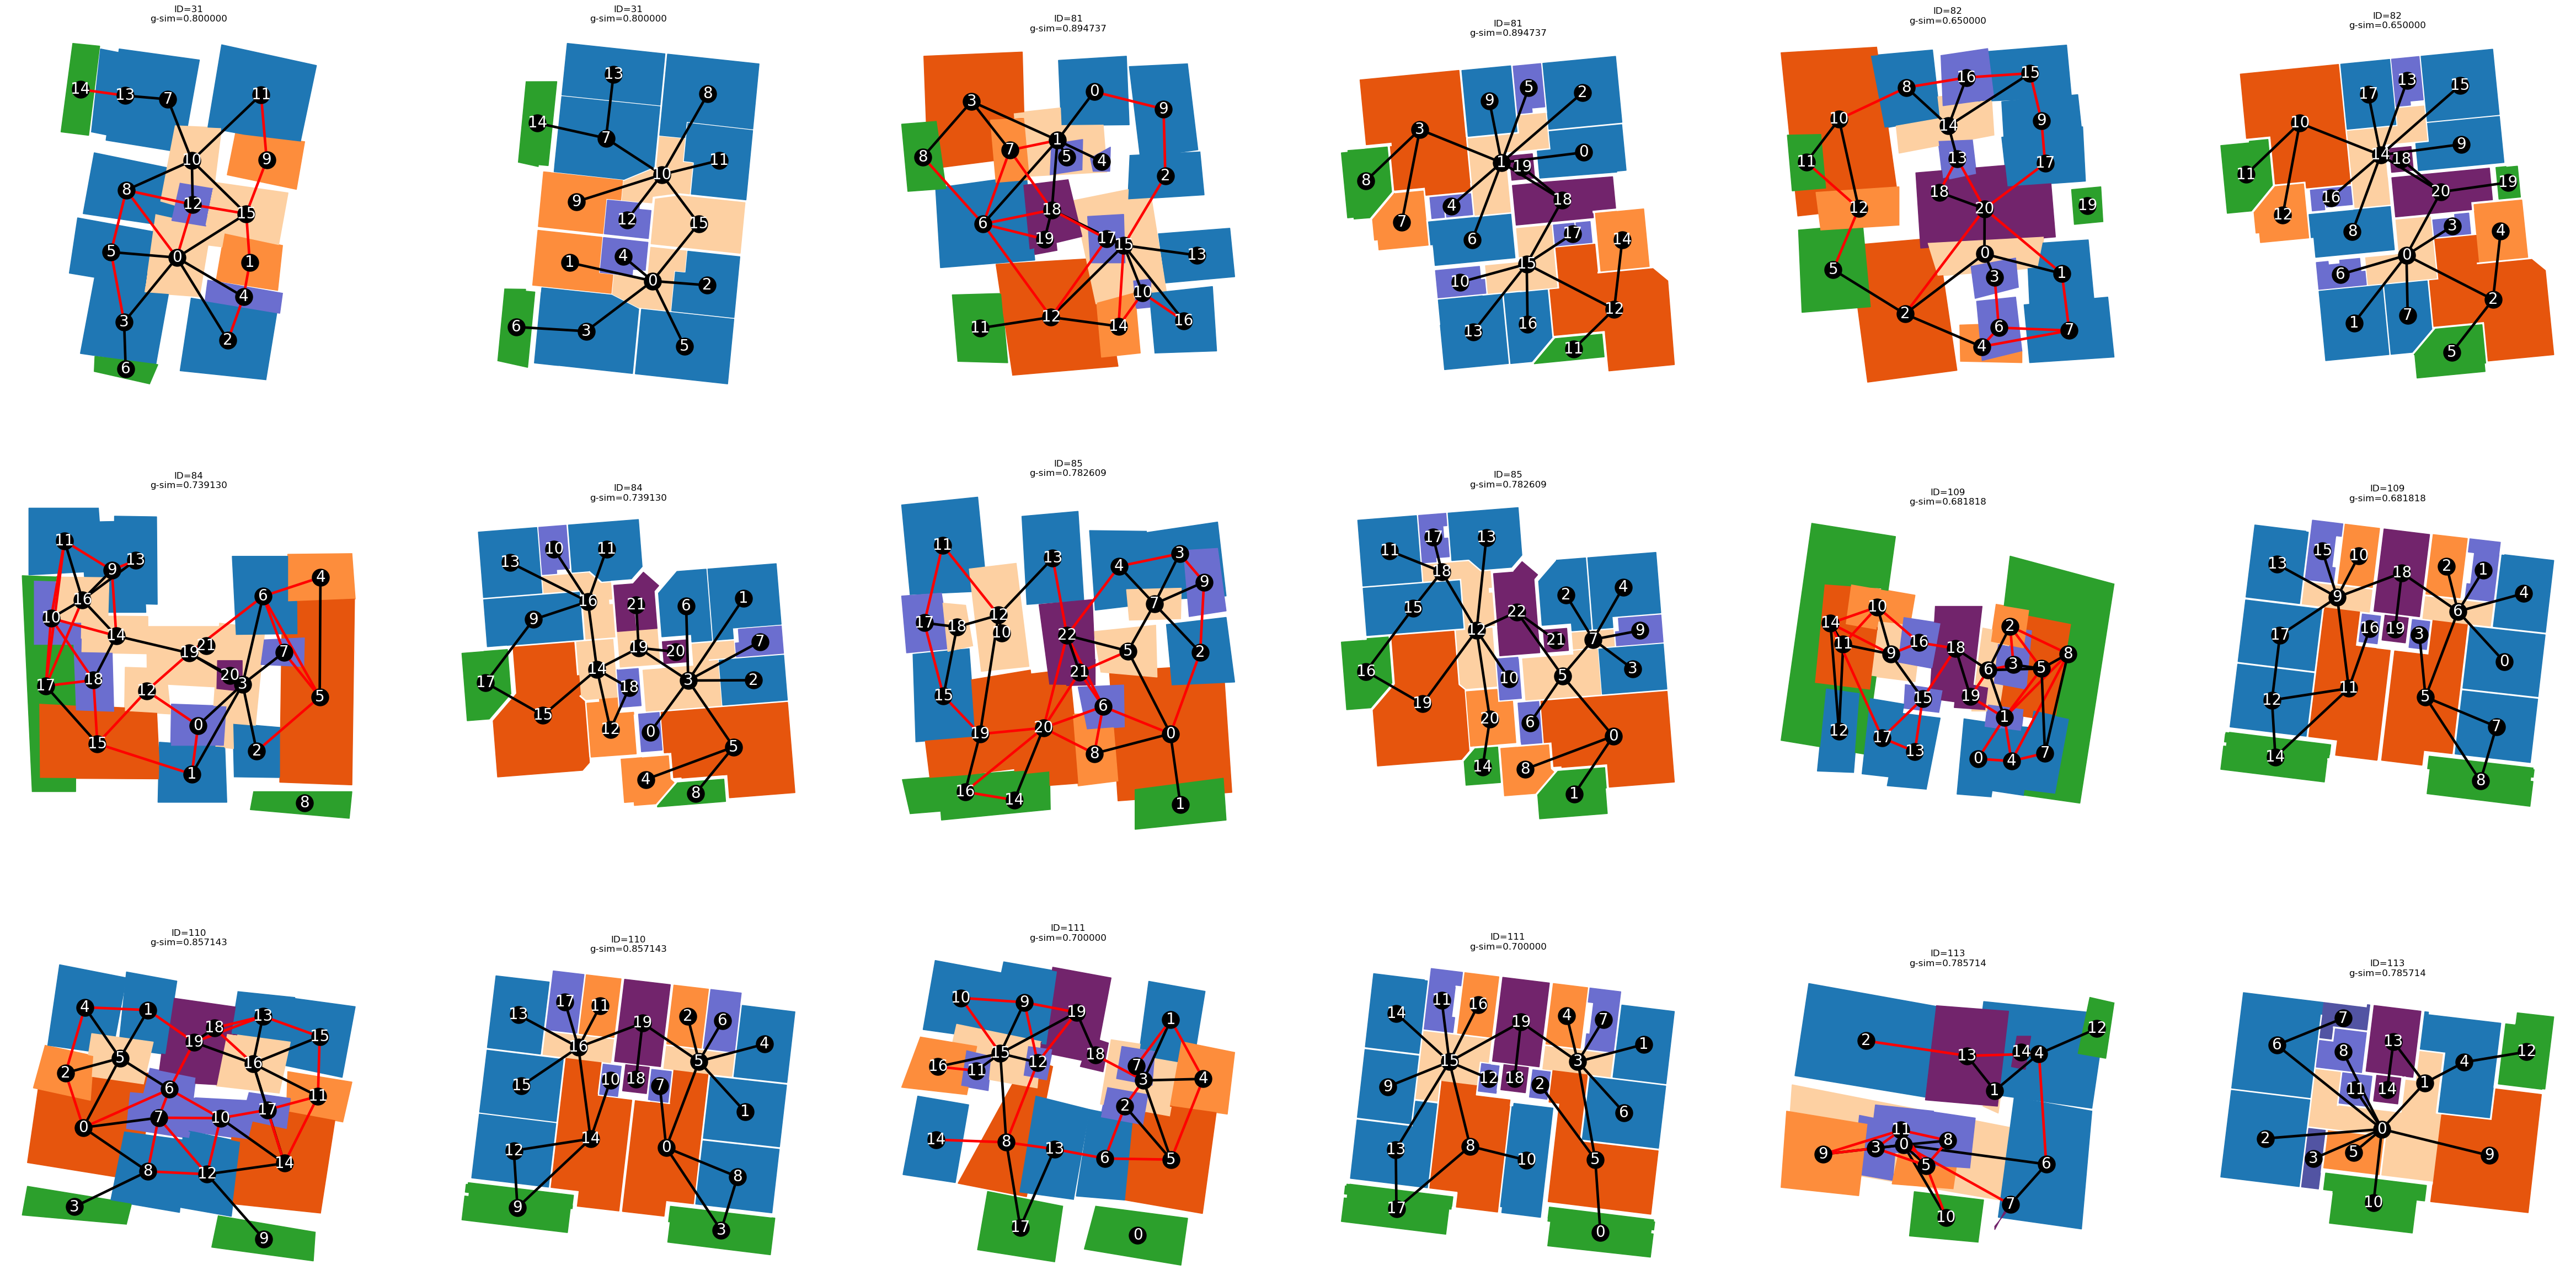

In [27]:
from plot import set_figure, plot_polygon
from constants import CMAP_ROOMTYPE, COLORS_ROOMTYPE

fs = 10
fig, axs = set_figure(nc=6,nr=3, fs=10) #, fs_title=5)

for i, ax in enumerate(axs):

    j = int(np.floor(i / 2))

    dwelling = dwellings[j]
    id = dwelling['id']

    # load predicted and ground truth graphs
    graph_extract_buffer_amount = 5
    graph_pred = extract_graph(dwelling, buffer_amount=graph_extract_buffer_amount)
    graph_out = load_pickle(os.path.join(datapath_reference, 'graph_out', f'{id}.pickle'))

    # compute score
    count = 0
    edge_colors = []
    for edge in graph_pred.edges:

        if edge in graph_out.edges:
            edge_colors.append('black')
            count += 1
        else:
            edge_colors.append('red')

    graph_similarity = count / len(graph_out.edges)

    # plot PREDICTED
    if i % 2 == 0:
        # room geometries are in the "geometry" attribute
        rooms = [Polygon(n) for _, n in graph_pred.nodes('geometry')]
        # loop over room and color combination and plot
        colors = [np.array(CMAP_ROOMTYPE(n)).reshape(1,4) for _, n in graph_pred.nodes('room_type')]
        [plot_polygon(ax, room, fc=color, ec=color) for room, color in zip(rooms, colors)]

        # plot graph
        # coloring is based on our own colormap "CMAP_ROOMTYPE"
        # positioning of the nodes are in the "centroid" attribute
        pos = {n: np.array(graph_pred.nodes[n]['centroid']) for n in graph_pred.nodes}

        plot_graph(graph_pred, ax, c_node='black', dw_edge=False, c_edge=[edge_colors]*4, pos=pos, node_size=fs*50, edge_size=fs/3, labels=True, label_size=20)

        _ = ax.set_aspect('equal')
        ax.set_title(f'ID={id}\n'
                  f'g-sim={graph_similarity:4f}')

    elif i % 2 == 1:

        # plot full layout (similar to image)
        # room geometries are in the "geometry" attribute
        rooms = [Polygon(n) for _, n in graph_out.nodes('geometry')]
        # loop over room and color combination and plot
        colors = [np.array(CMAP_ROOMTYPE(n)).reshape(1,4) for _, n in graph_out.nodes('room_type')]
        [plot_polygon(ax, room, fc=color, ec=color) for room, color in zip(rooms, colors)]

        # plot graph
        # coloring is based on our own colormap "CMAP_ROOMTYPE"
        # positioning of the nodes are in the "centroid" attribute
        pos = {n: np.array(graph_out.nodes[n]['centroid']) for n in graph_out.nodes}
        labels = {n:n for n in graph_out.nodes}
        plot_graph(graph_out, ax, c_node='black', dw_edge=False, c_edge=['black']*4, pos=pos, node_size=fs*50, edge_size=fs/3, labels=True)

        _ = ax.set_aspect('equal')

        ax.set_title(f'ID={id}\n'
                  f'g-sim={graph_similarity:4f}')

### Mean Graph Similarity

In [ ]:
dwellings = []

print(sub_root)

for file in tqdm(os.listdir(sub_root)):

    if not file.endswith(".pkl"):
        continue

    # get graph batch
    try:
        graph_batch = load_pickle(os.path.join(sub_root, file))
        batch_size = graph_batch["sample"].shape[1]

        # get geometry dicts
        geom_dicts = extract_geom_from_batch(graph_batch, batch_size=batch_size)

        for geom_dict in geom_dicts:
            dwellings.append(extract_polygons_from_geom_dict(geom_dict))
    except Exception as e:
        raise e

In [29]:
graph_extract_buffer_amount = 5

graph_distances = {}

for dwelling in tqdm(dwellings):

    id = dwelling['id']

    try:
        # load predicted and ground truth graphs
        graph = extract_graph(dwelling, buffer_amount=graph_extract_buffer_amount)
    except:
        continue
    graph_out = load_pickle(os.path.join(datapath_reference, 'graph_out', f'{id}.pickle'))

    # compute score
    count = 0
    edge_colors = []
    for edge in graph_out.edges:
        if edge in graph.edges:
            count += 1
        else:
            edge_colors.append('red')

    graph_distances[id] = count / len(graph_out.edges)

  0%|          | 0/791 [00:00<?, ?it/s]

In [30]:
np.mean(list(graph_distances.values()))

0.7624304318859532

In [31]:
np.nanmean(list(graph_distances.values()))

0.7624304318859532

Mean Graph Similarity:	0.762


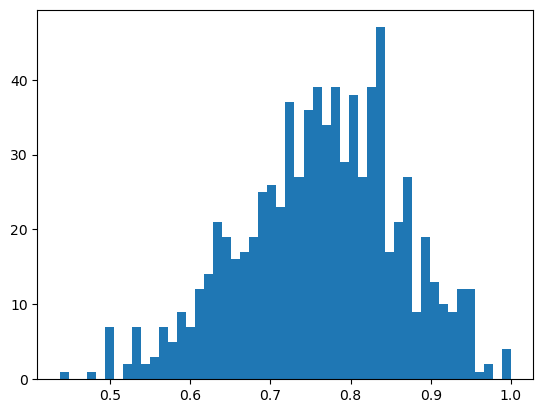

In [32]:
mean_graph_similarity = np.nanmean(list(graph_distances.values()))
print(f'Mean Graph Similarity:\t{mean_graph_similarity:.3f}')

_, ax = plt.subplots(1, 1)

_ = ax.hist(graph_distances.values(), bins=50)

### Mean Graph Similarity (per size category)

In [33]:
subsets = load_pickle(os.path.join(datapath_subsets, '10-subsets-nr-areas.pickle'))

keys = list(subsets.keys())
print(keys)

key_map = {
    '20': '20',
    '25': '30',
    '30': '30',
    '35': '40',
    '40': '40',
    '45': '50',
    '50': '50',
    '55': '60',
    '60': '60',
    '1000': '60'
}

graph_distances_rooms = {
    '20' : [],
    '30' : [],
    '40' : [],
    '50' : [],
    '60' : []
}

for dwelling in tqdm(dwellings):

    id = dwelling['id']

    if id not in graph_distances:
        print(f"skipping {id=}")
        continue

    for key in keys:
        if id in subsets[key]:
            new_key = key_map[str(key)]
        else: continue

    # compute miou
    graph_distances_rooms[new_key].append(graph_distances[id])

[20, 25, 30, 35, 40, 45, 50, 55, 60, 1000]


  0%|          | 0/791 [00:00<?, ?it/s]

In [34]:
mean_graph_distances_rooms = {key: {"compatibility": f"{np.mean(dist):.3f}"} for key, dist in graph_distances_rooms.items()}
print(mean_graph_distances_rooms)

pd.DataFrame(mean_graph_distances_rooms).to_csv()

{'20': {'compatibility': '0.760'}, '30': {'compatibility': '0.756'}, '40': {'compatibility': '0.758'}, '50': {'compatibility': '0.776'}, '60': {'compatibility': '0.792'}}


',20,30,40,50,60\ncompatibility,0.760,0.756,0.758,0.776,0.792\n'